<a href="https://colab.research.google.com/github/sobhanshukueian/SimCLR/blob/main/SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import shutil
import cv2
import glob
import matplotlib
# matplotlib.use("TKAgg")
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 16

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
root_path = "./data"
# Download Dataset
labeled = datasets.STL10(root=root_path, split='train', download=True)
unlabeled = datasets.STL10(root=root_path, split='unlabeled', download=True)
test = datasets.STL10(root=root_path, split="test", download=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
unlabeled = list(unlabeled)[:2000]
test = list(test)[:500]

In this work, we sequentially apply three simple augmentations: random cropping followed by resizing back to the original size, random color distortions, and random Gaussian blur. As shown in Section 3, combining random crop and color distortion is crucial to achieving good performance.

In [5]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])
val_transformation = transforms.Compose([transforms.Resize((96,96)), transforms.ToTensor()])

In [6]:
class STL10Unlabeld(Dataset):
    def __init__(self, transform, dataset):
        self.transform = transform
        self.dataset=dataset

        self.classes=['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck','unlabelled']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label=self.dataset[index]
        if self.transform is not None:
            img0 = self.transform(img)
            img1 = self.transform(img)
        

        return img0, img1, label

We randomly sample a minibatch of N examples and define the contrastive prediction task on pairs of augmented examples derived from the minibatch, resulting in 2N data points.

In [7]:
# Initialize the network
siamese_dataset = STL10Unlabeld(contrast_transforms, unlabeled)
siamese_testset = STL10Unlabeld(val_transformation, test)

In [8]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset, shuffle=False, num_workers=2, batch_size=BATCH_SIZE)

# Load the testing dataset
test_dataloader = DataLoader(siamese_testset, shuffle=False, num_workers=2, batch_size=BATCH_SIZE)

In [9]:
train_features = next(iter(train_dataloader))
print(len(train_dataloader))
print("Train Images 1 Shape: {}\nTrain Images 2 Shape: {}\nTrain Data Labels Shape: {}".format(train_features[0].shape, train_features[1].shape, train_features[2].shape,))

test_features = next(iter(train_dataloader))
print(len(test_dataloader))
print("Test Images 1 Shape: {}\nTest Images 2 Shape: {}\nTest Data Labels Shape: {}".format(test_features[0].shape, test_features[1].shape, test_features[2].shape,))


125
Train Images 1 Shape: torch.Size([16, 3, 96, 96])
Train Images 2 Shape: torch.Size([16, 3, 96, 96])
Train Data Labels Shape: torch.Size([16])
32
Test Images 1 Shape: torch.Size([16, 3, 96, 96])
Test Images 2 Shape: torch.Size([16, 3, 96, 96])
Test Data Labels Shape: torch.Size([16])


In [10]:
# Showing images
def show_batch(data, cols = BATCH_SIZE):
    fig, ax = plt.subplots(2, cols, figsize=(cols*20, 2*20))
    for index in range(cols):
        ax[0, index].imshow(data[0][index].view(3, 96,96).permute(1 , 2 , 0), interpolation='nearest')
        ax[1, index].imshow(data[1][index].view(3, 96,96).permute(1 , 2 , 0), interpolation='nearest')
    plt.show()
    print(data[2].numpy().reshape(-1))

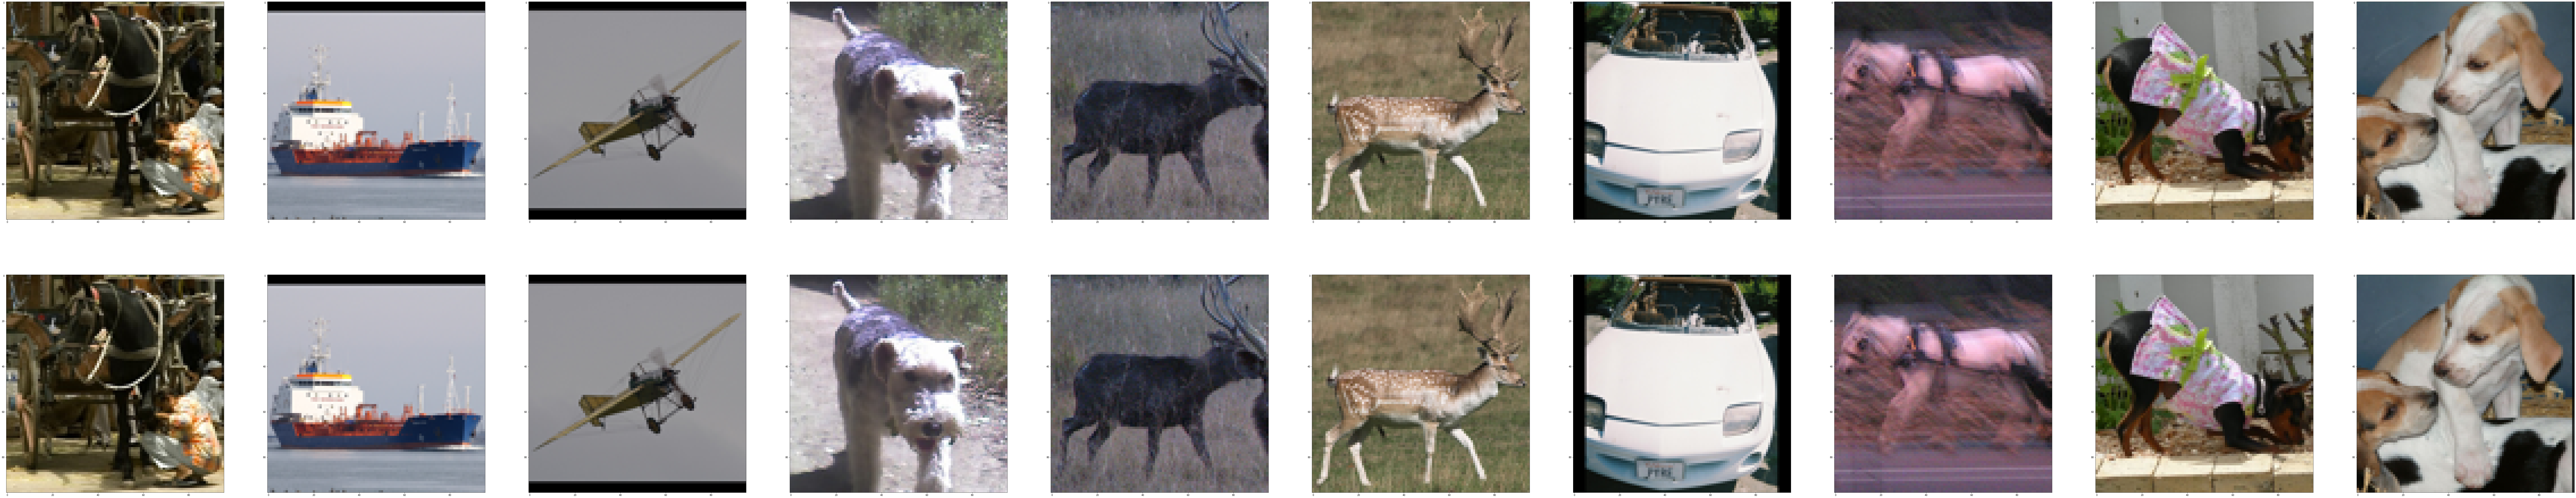

[6 8 0 5 4 4 2 6 5 5]


In [11]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_testset, shuffle=True, num_workers=0, batch_size=10)

# Extract one batch
example_batch = next(iter(vis_dataloader))
show_batch(example_batch, cols=10)

Our framework allows various choices of network architecture without any constraints. We opt for simplicity and adopt the commonly used ResNet.

In [18]:
OUTPUT_EMBEDDING_SIZE = 32
OUTPUT_SIZE = 32


#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.convnet = torchvision.models.resnet18(num_classes=4*OUTPUT_EMBEDDING_SIZE)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*OUTPUT_EMBEDDING_SIZE, OUTPUT_SIZE)
        )
    def forward(self, input1):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.convnet(input1)

        return output1

temp1 = torch.rand((6, 3, 96, 96))
temp_model = SiameseNetwork()
res = temp_model(temp1)
res.size()

torch.Size([6, 32])

In [19]:
# Define the InfoNCELoss Loss Function
class InfoNCELoss(torch.nn.Module):
    def __init__(self):
        super(InfoNCELoss, self).__init__()
    def forward(self, output1):
        cos_sim = F.cosine_similarity(output1[:,None,:], output1[None,:,:], dim=-1)
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        cos_sim = cos_sim #/ self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()
        return nll

In [20]:
def get_color(idx):
    return list(matplotlib.colors.cnames.keys())[idx]
  
def get_colors(idxs):
    res = []
    for idx in idxs:
      res.append(get_color(idx))
    return res 

We randomly sample a minibatch of N examples and define the contrastive prediction task on pairs of augmented examples derived from the minibatch, resulting in 2N data points. We do not sample negative examples explicitly. Instead, given a cheerful pair, similar to (Chen et al., 2017), we treat the other 2(N -1) augmented examples within a minibatch as negative examples.

In [21]:
#@title Some Configurations
EPOCHS = 50 #@param {type:"integer"}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #@param
VERBOSE = 0 #@param [0, 1, 2, 3] {type:"raw"}
SAVE_PLOTS = True #@param {type:"boolean"}
VISUALIZE_PLOTS = True #@param {type:"boolean"}
SAVE_DIR = "/content/drive/MyDrive/SimCLR/runs" #@param
MODEL_NAME = "SimCLR Model" #@param
WEIGHTS = None

Start Training Process 
Time: Thu Mar  9 16:24:07 2023


Epoch: 0/50	Train Loss: 3.456805467605591  : 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]
Epoch: 0/50	Validation Loss Loss: 1.9410736560821533  : 100%|██████████| 32/32 [00:00<00:00, 38.03it/s]


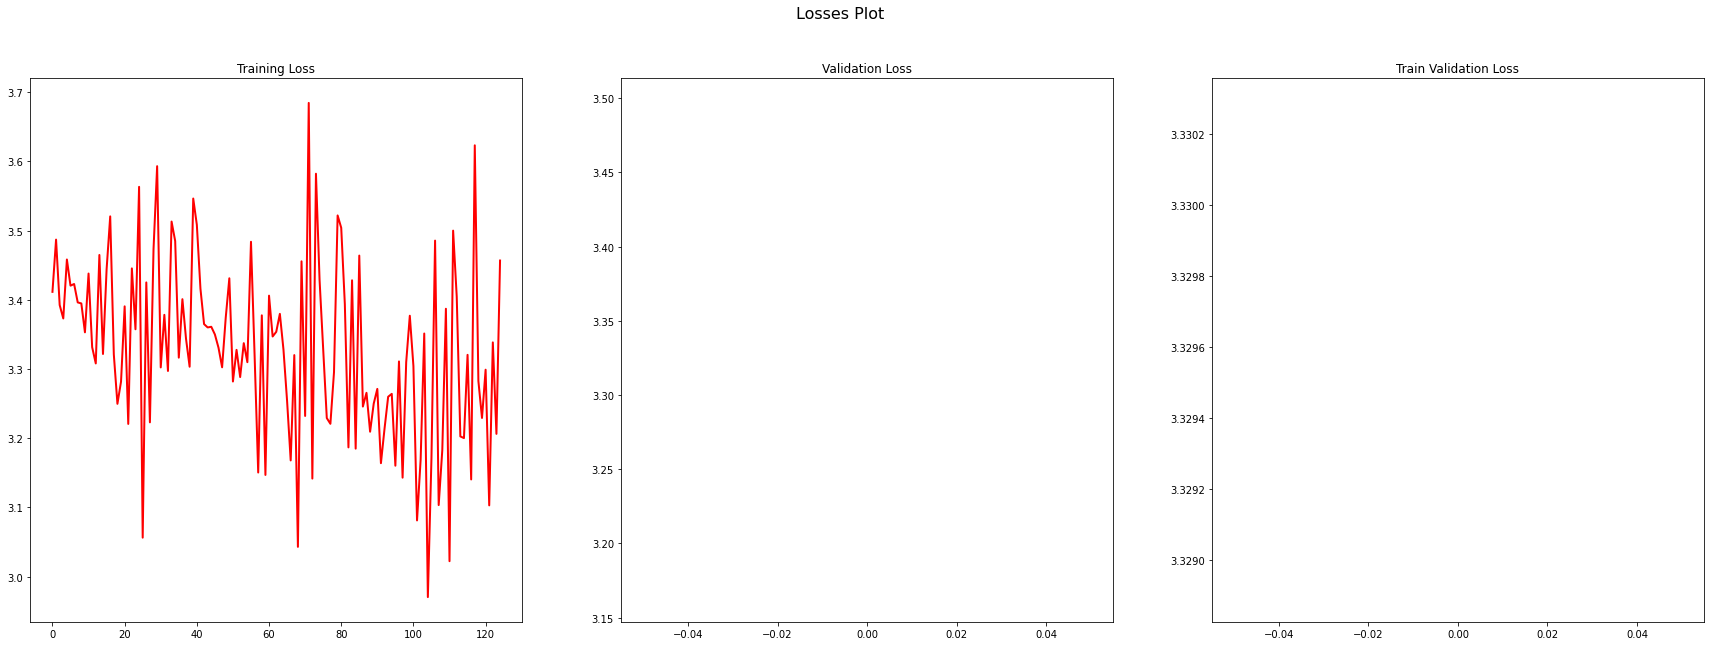

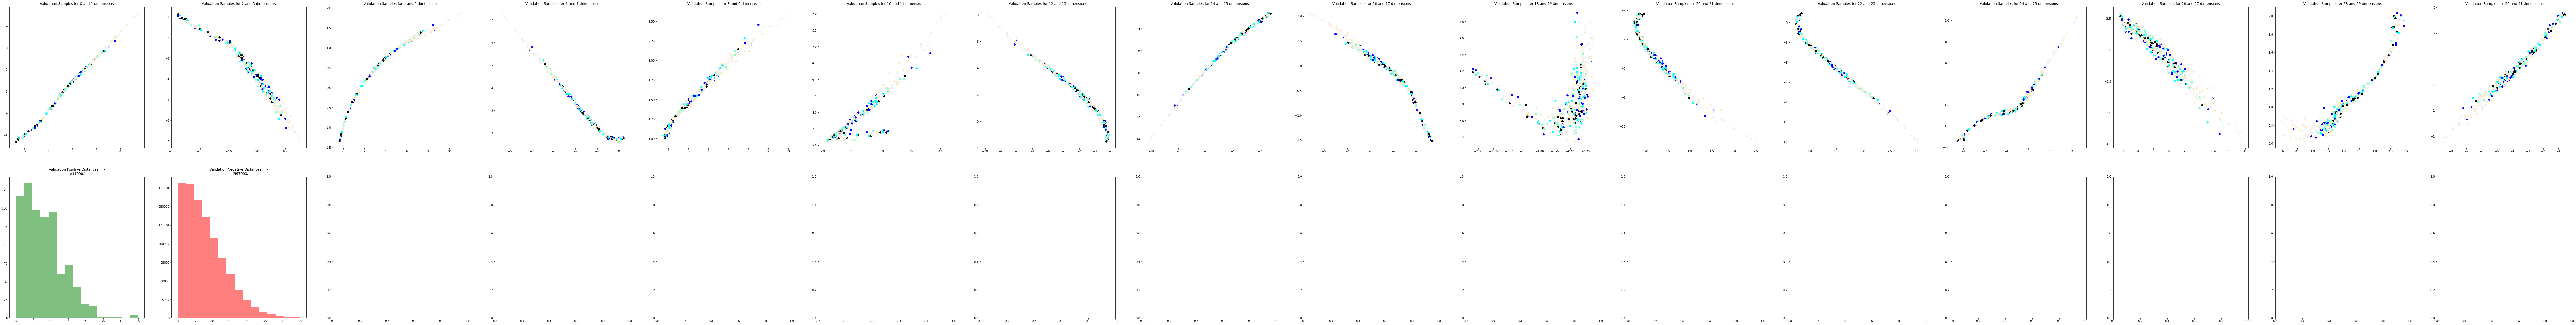

Epoch: 1/50	Train Loss: 3.0880045890808105  : 100%|██████████| 125/125 [00:20<00:00,  6.09it/s]
Epoch: 1/50	Validation Loss Loss: 1.826312780380249  : 100%|██████████| 32/32 [00:01<00:00, 31.77it/s]


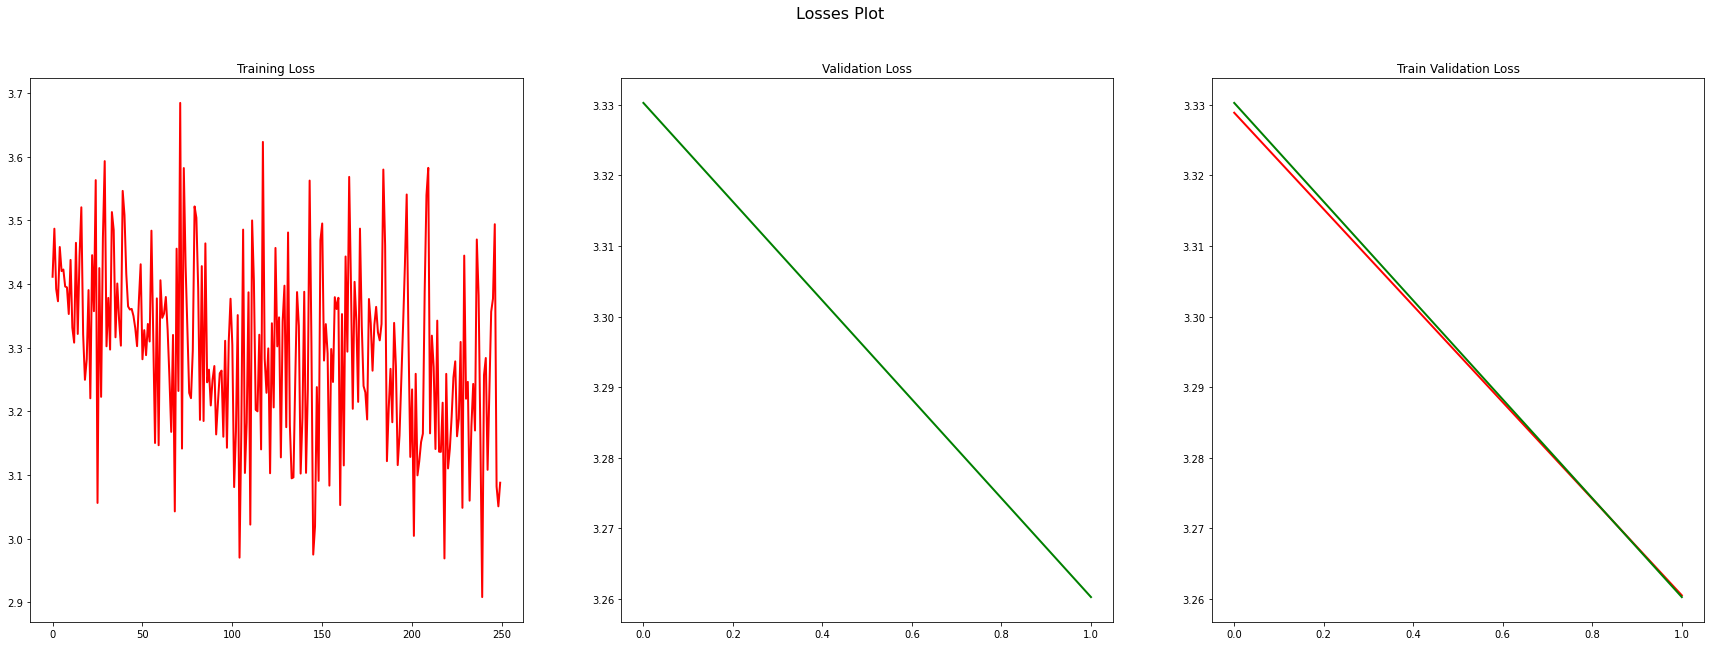

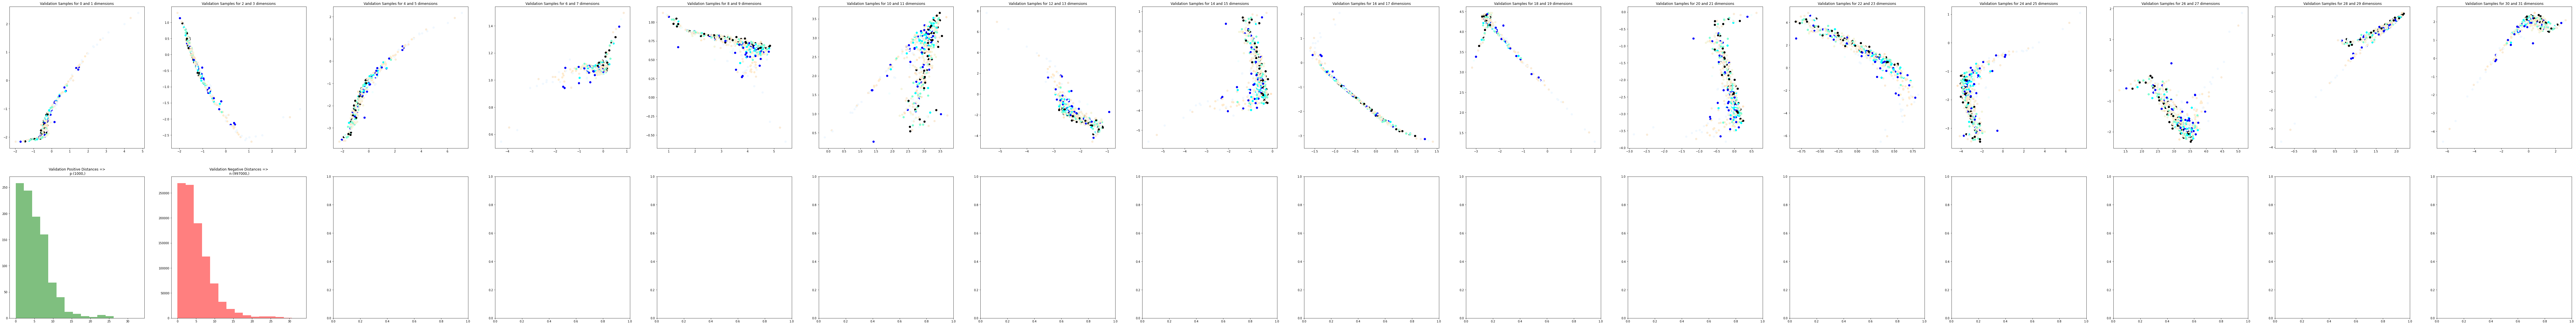

Epoch: 2/50	Train Loss: 3.2626705169677734  : 100%|██████████| 125/125 [00:22<00:00,  5.57it/s]
Epoch: 2/50	Validation Loss Loss: 1.864380121231079  : 100%|██████████| 32/32 [00:01<00:00, 28.47it/s]


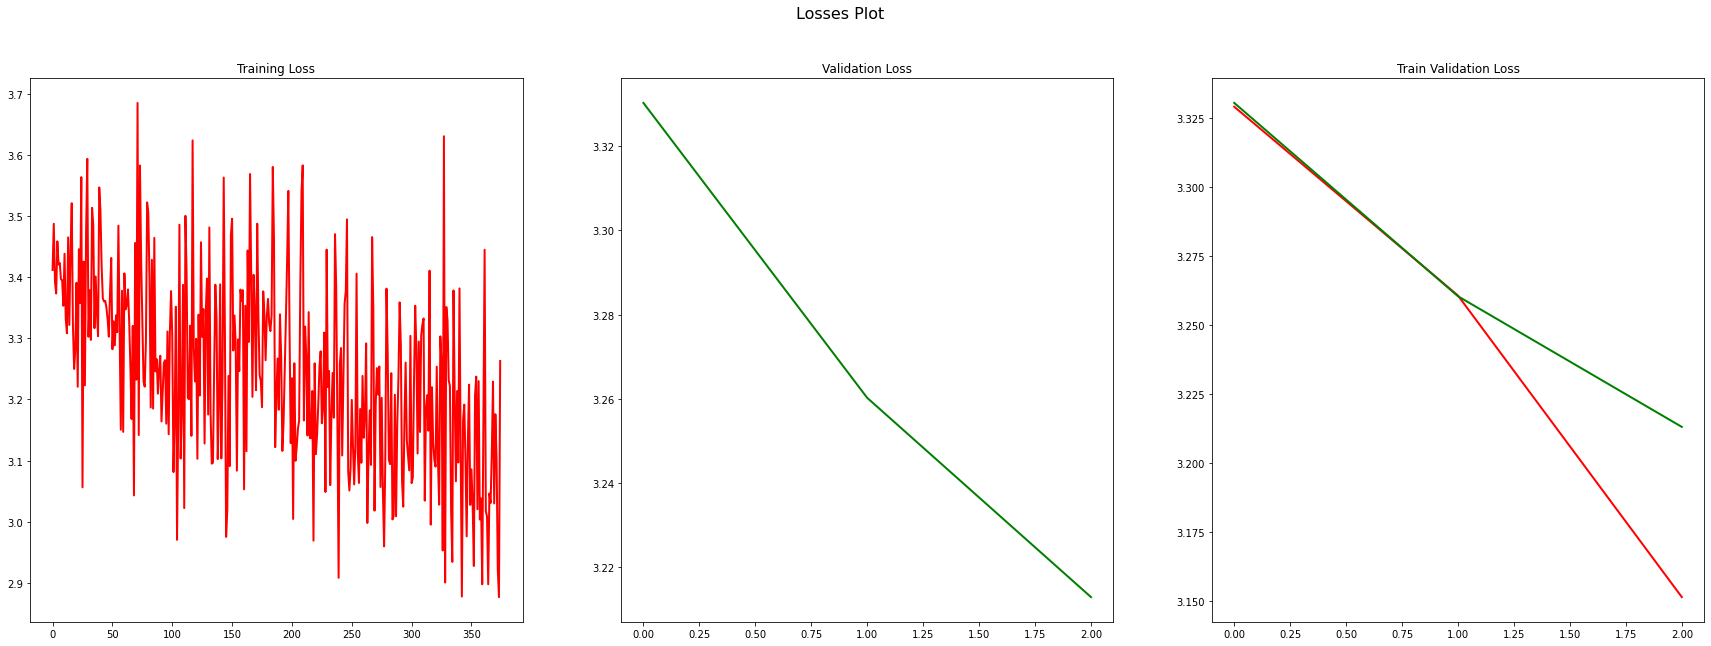

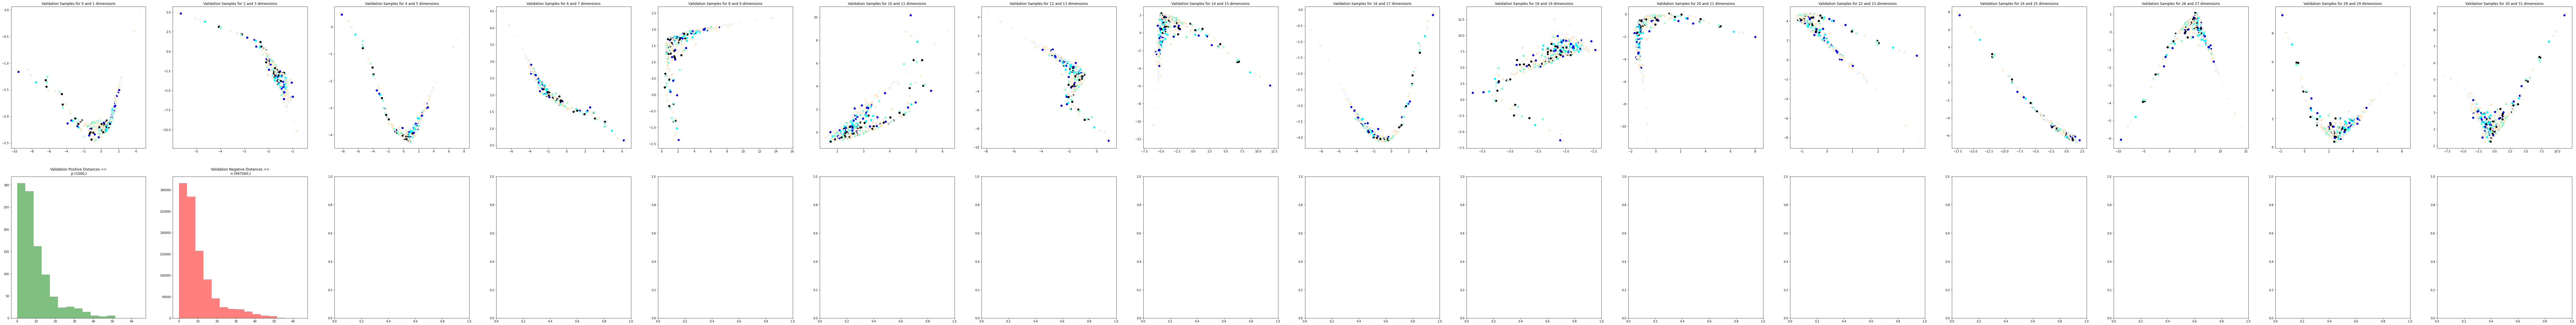

Epoch: 3/50	Train Loss: 3.101470470428467  : 100%|██████████| 125/125 [00:23<00:00,  5.39it/s]
Epoch: 3/50	Validation Loss Loss: 1.7820396423339844  : 100%|██████████| 32/32 [00:01<00:00, 28.27it/s]


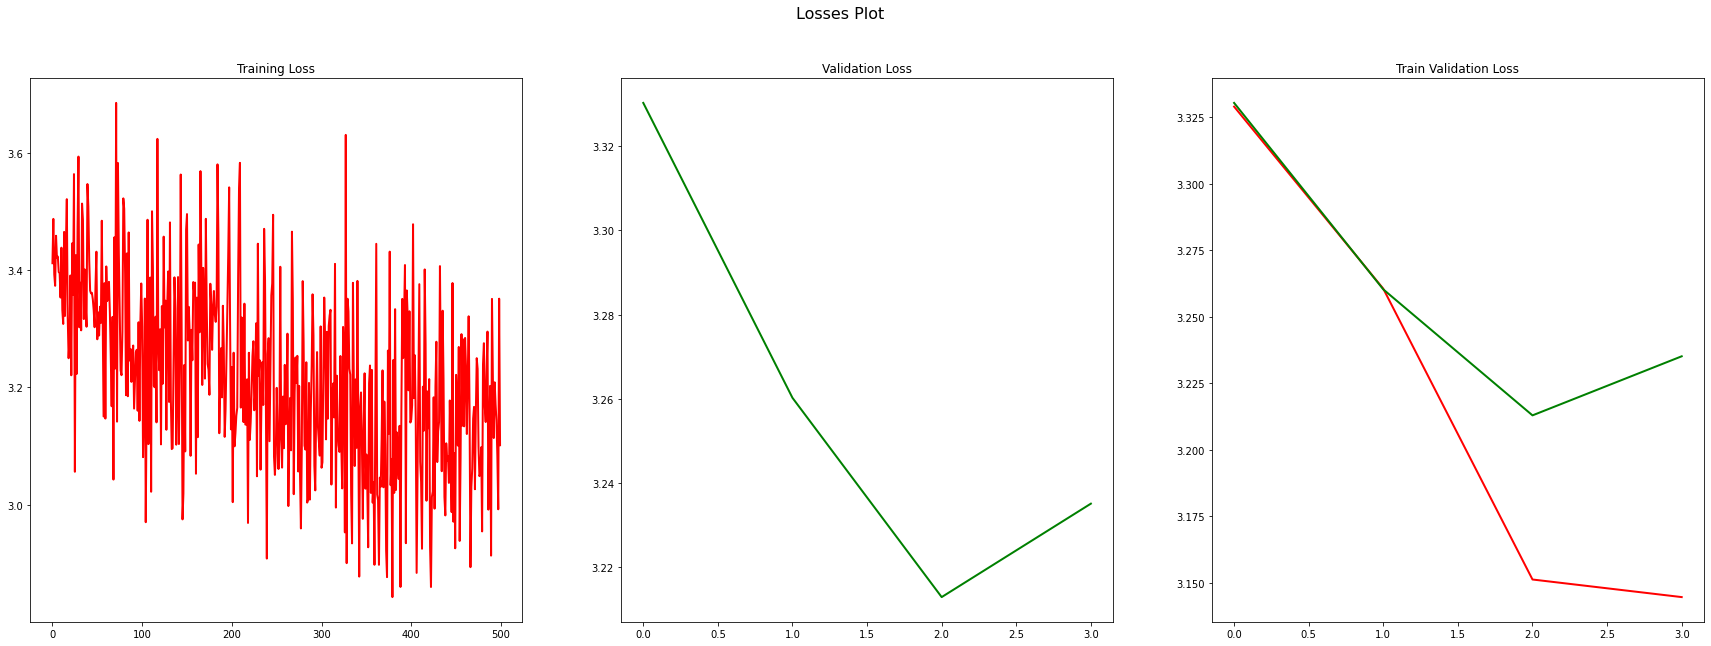

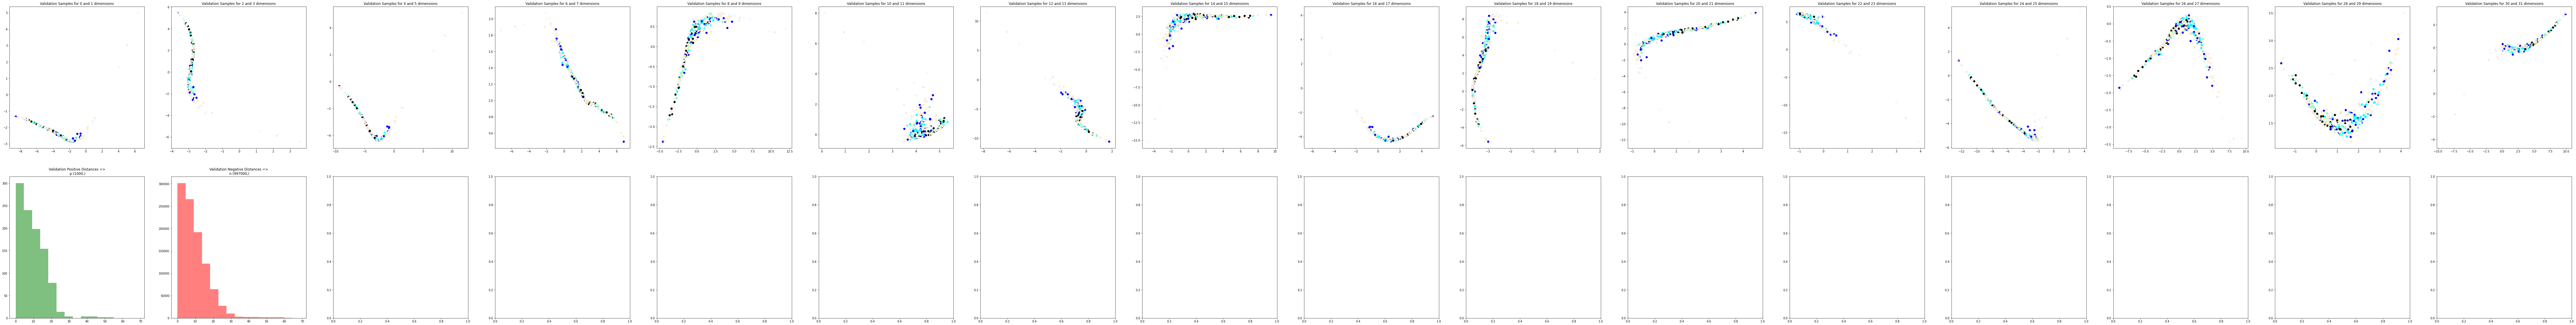

Epoch: 4/50	Train Loss: 3.060492992401123  : 100%|██████████| 125/125 [00:23<00:00,  5.24it/s]
Epoch: 4/50	Validation Loss Loss: 1.9285801649093628  : 100%|██████████| 32/32 [00:01<00:00, 23.46it/s]


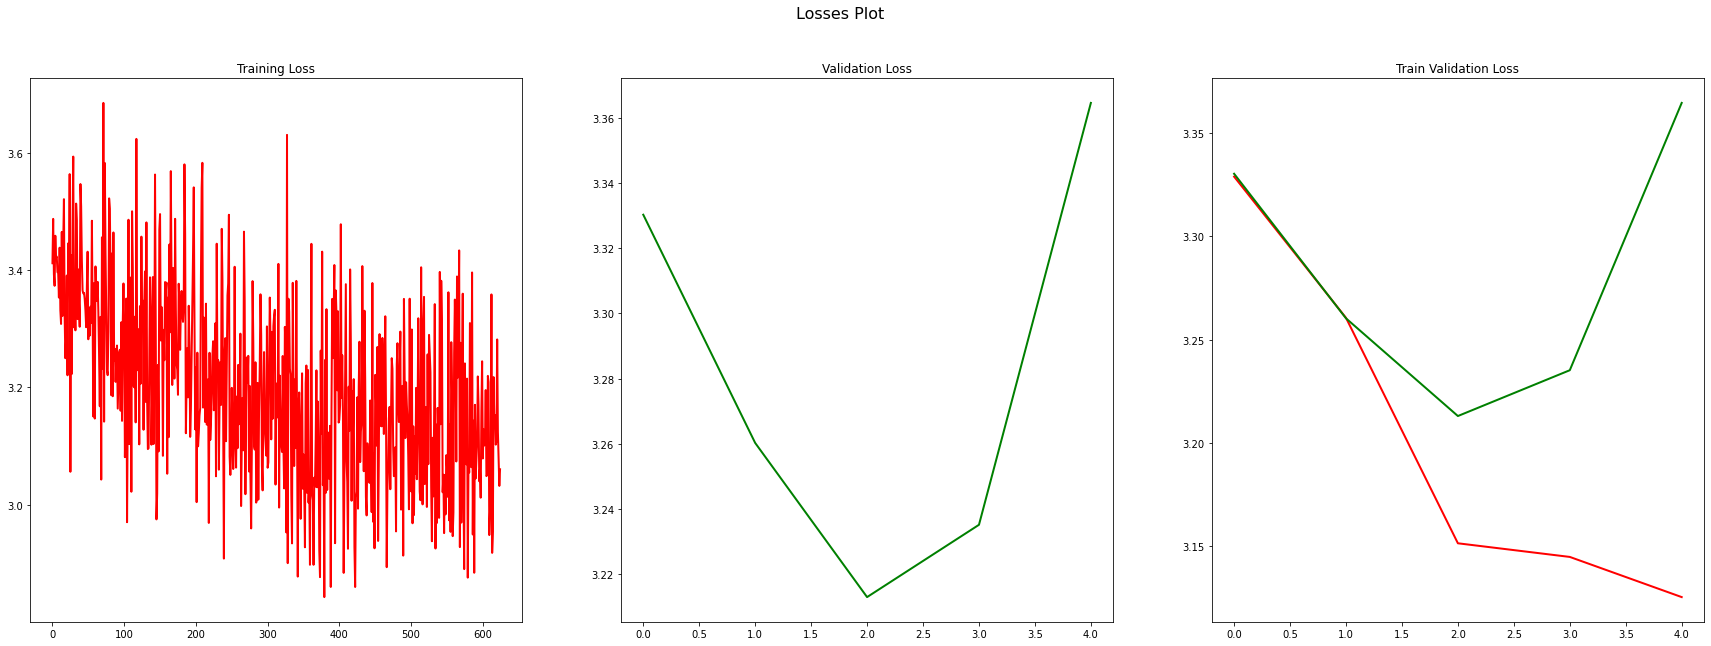

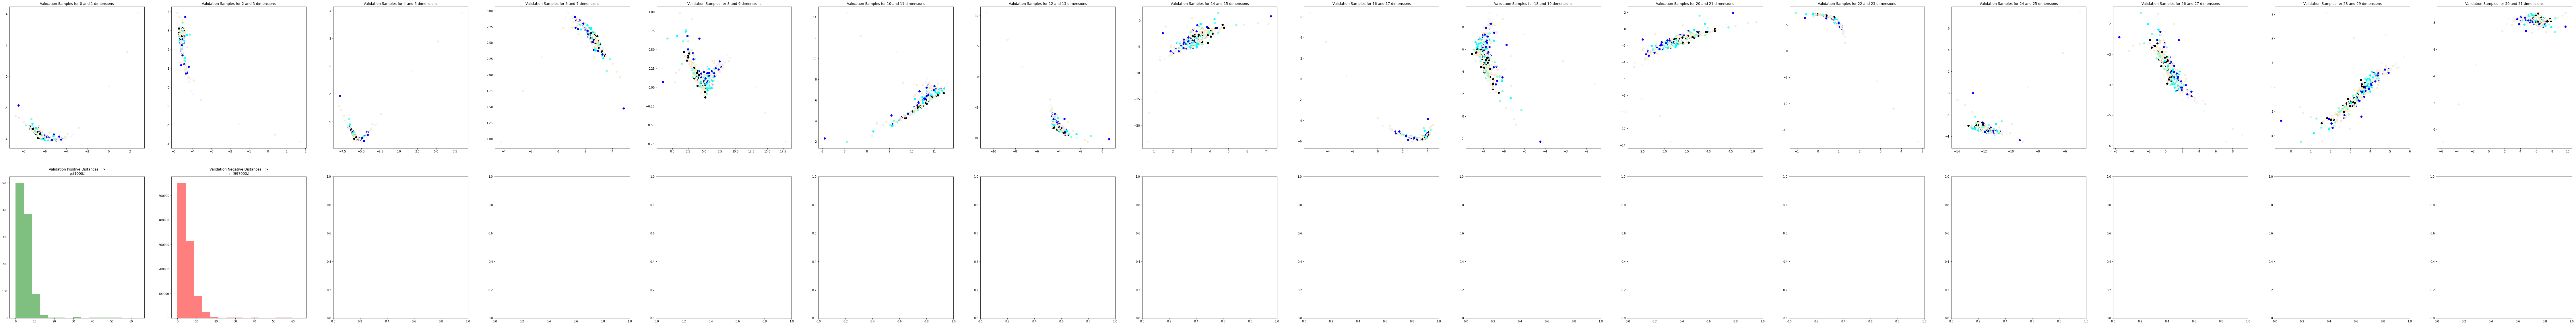

Epoch: 5/50	Train Loss: 2.984424591064453  : 100%|██████████| 125/125 [00:24<00:00,  5.03it/s]
Epoch: 5/50	Validation Loss Loss: 1.9091216325759888  : 100%|██████████| 32/32 [00:01<00:00, 26.98it/s]


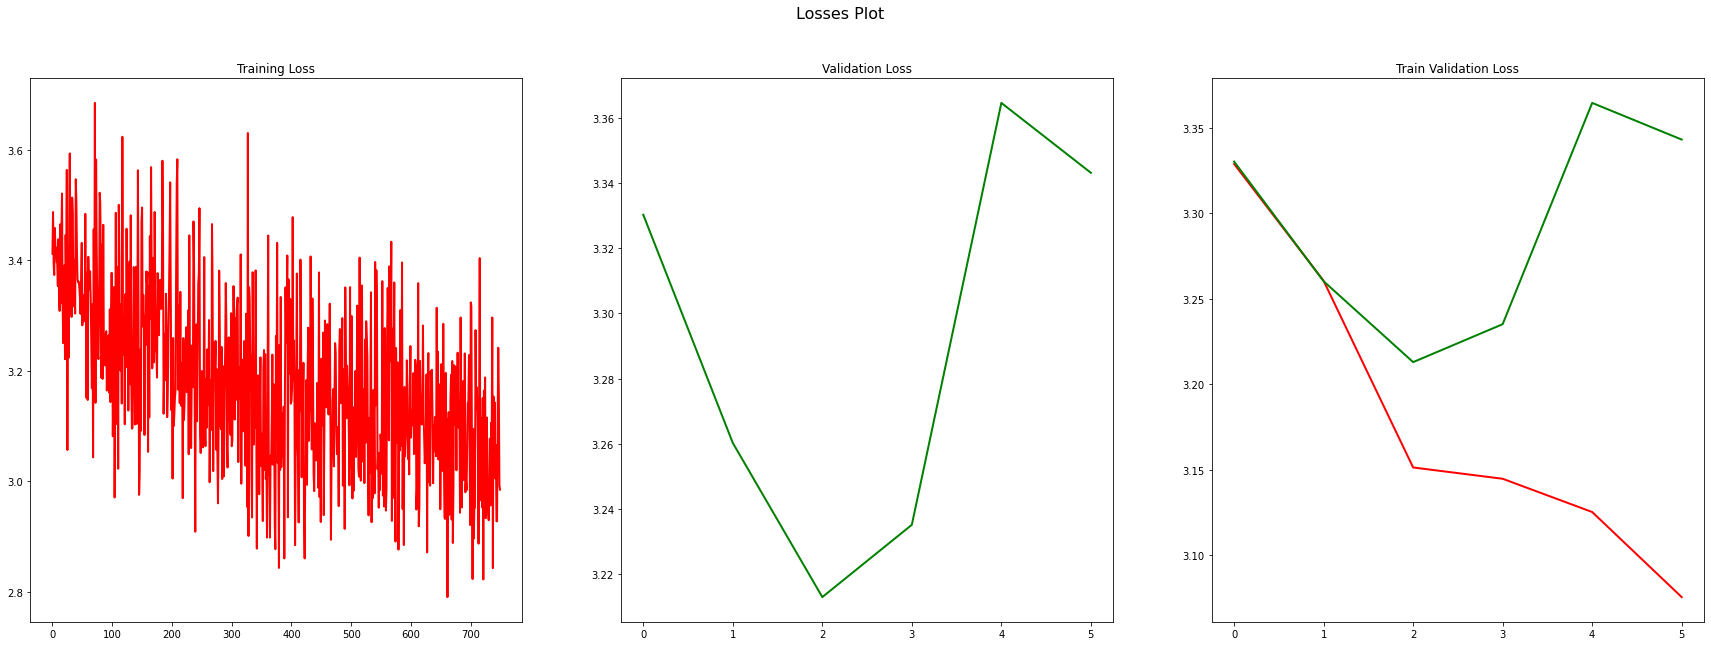

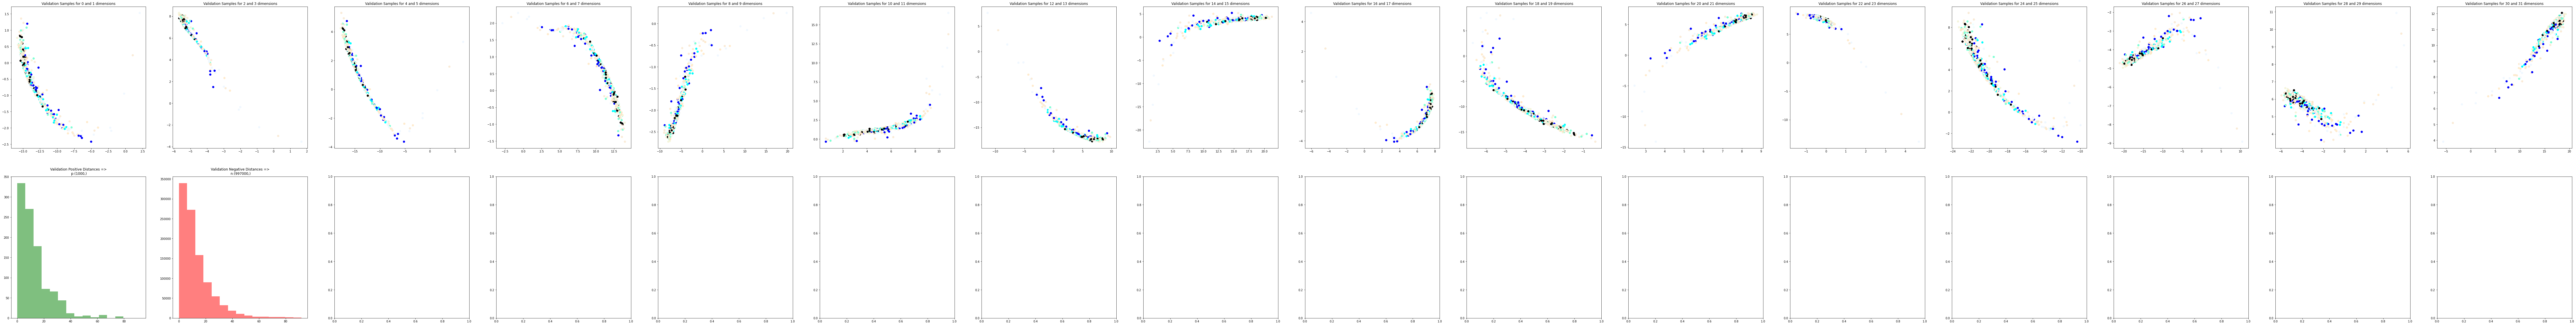

Epoch: 6/50	Train Loss: 3.1149516105651855  : 100%|██████████| 125/125 [00:25<00:00,  4.99it/s]
Epoch: 6/50	Validation Loss Loss: 1.771547794342041  : 100%|██████████| 32/32 [00:01<00:00, 22.43it/s]


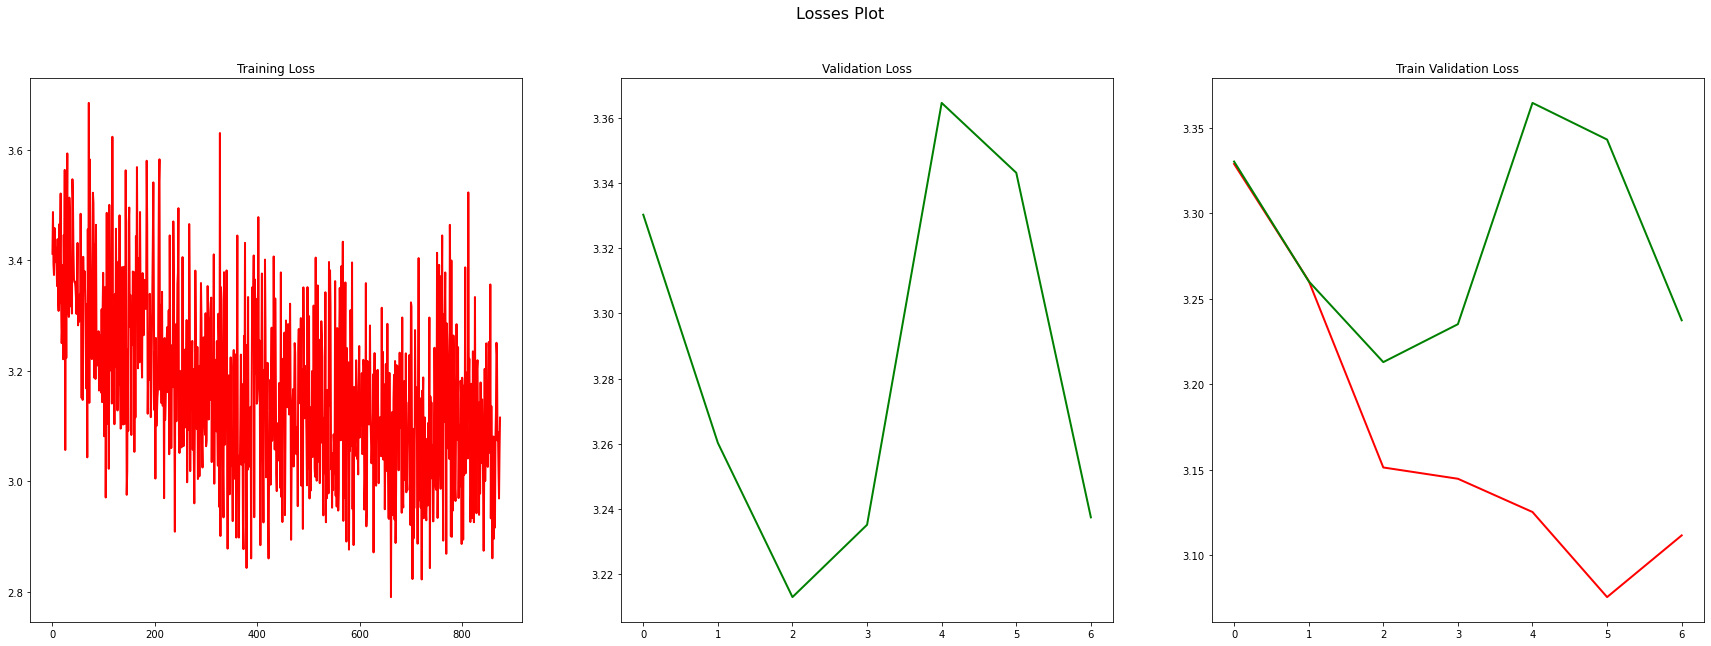

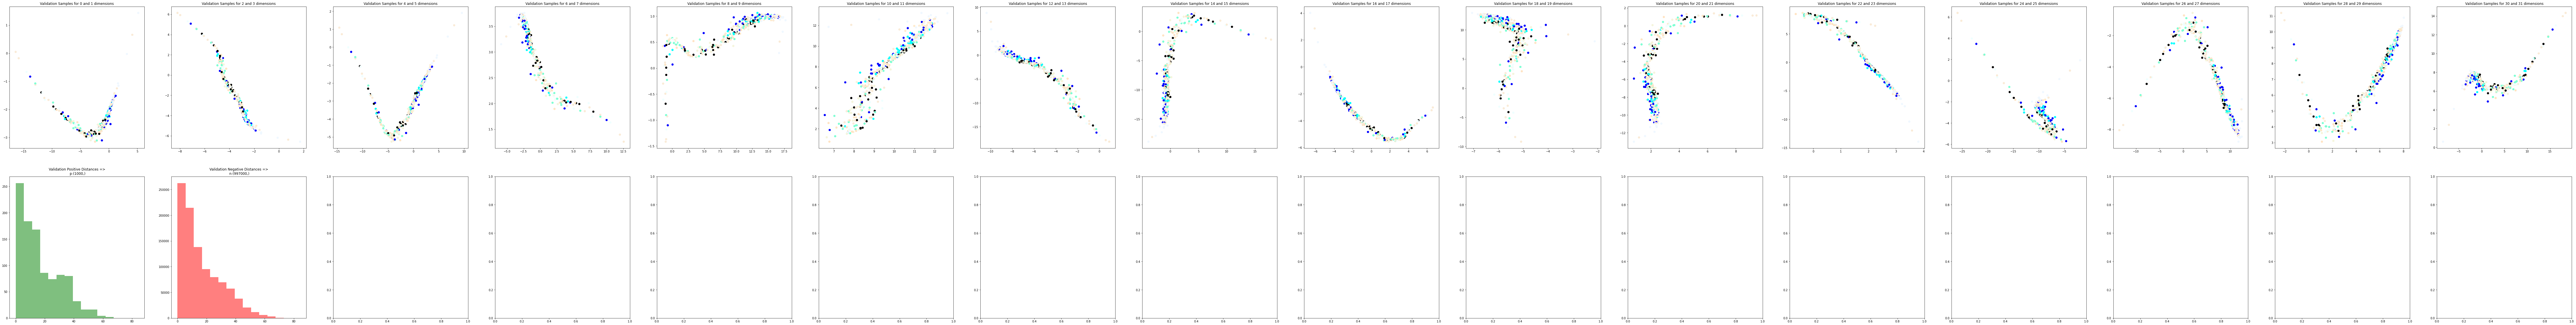

Epoch: 7/50	Train Loss: 3.0559604167938232  : 100%|██████████| 125/125 [00:27<00:00,  4.50it/s]
Epoch: 7/50	Validation Loss Loss: 1.8539824485778809  : 100%|██████████| 32/32 [00:01<00:00, 25.28it/s]


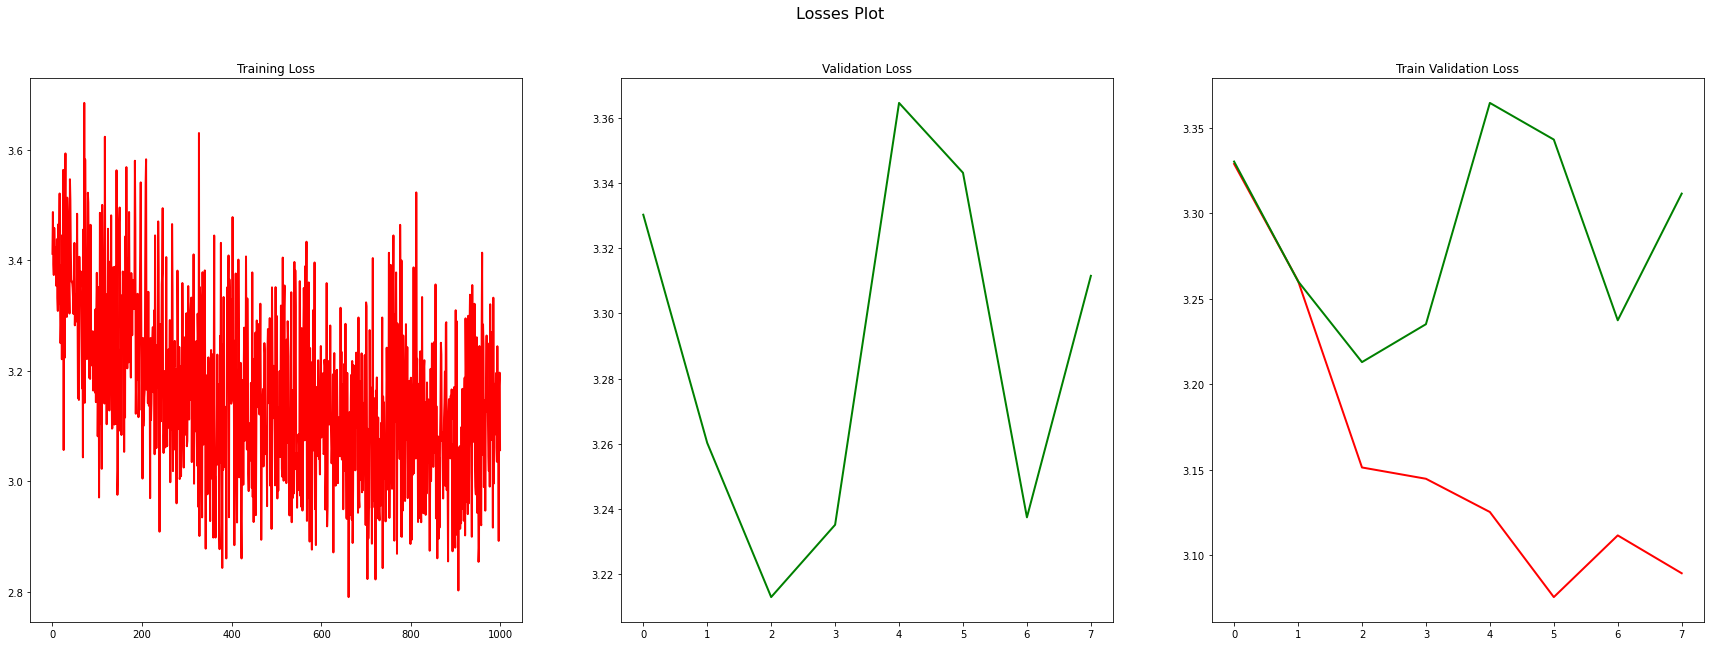

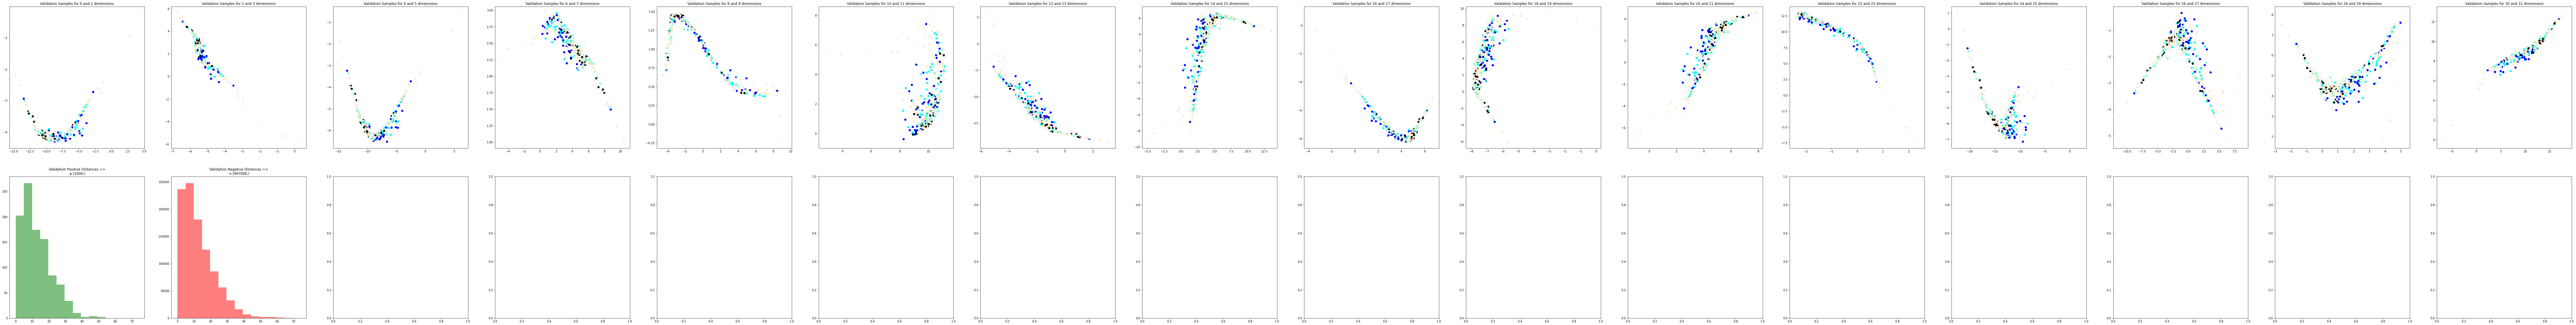

Epoch: 8/50	Train Loss: 2.9241654872894287  :   9%|▉         | 11/125 [00:03<00:25,  4.42it/s]

In [ ]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json
from sklearn.metrics import auc

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp
# from torch.utils.tensorboard import SummaryWriter

class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device=device, epochs=EPOCHS, batch_size=BATCH_SIZE, save_dir=SAVE_DIR, train_loader=train_dataloader, valid_loader=test_dataloader, weights=WEIGHTS, verbose=VERBOSE, visualize_plots=VISUALIZE_PLOTS, save_plots=SAVE_PLOTS, model_name=MODEL_NAME):
        self.device = device
        self.save_dir = save_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_ema = False
        self.model_name = model_name
        self.weights = weights
        self.visualize_plots = visualize_plots
        self.save_plots = save_plots
        # 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters
        self.verbose = verbose
        self.train_losses=[]
        self.val_losses=[]
        self.conf = {'Name' : self.model_name, 'Bacth_size' : self.batch_size, 'Max_iter_num' : '', 'Epochs' : self.epochs, 'Trained_epoch' : 0, 'Optimizer' : '', "Model" : '', 'Parameter_size' : ''}

        temm=0
        tmp_save_dir = self.save_dir
        while osp.exists(tmp_save_dir):
            tmp_save_dir = self.save_dir
            temm+=1
            tmp_save_dir += (str(temm))
        self.save_dir = tmp_save_dir
        del temm


        # get data loader
        self.train_loader, self.valid_loader = train_loader, valid_loader
        self.max_stepnum = len(self.train_loader)
        self.conf["Max_iter_num"] = self.max_stepnum
        
        # get model 
        self.model = self.get_model()
        if self.verbose > 2:
            self.count_parameters()

        # Get optimizer
        self.optimizer = self.get_optimizer()
    
        # tensorboard
        # self.tblogger = SummaryWriter(self.save_dir) 

# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model 
    def get_model(self):
        # Get Model Archutecture From Model Class.
        model = SiameseNetwork().to(self.device)

        # finetune if pretrained model is set
        if self.weights:  
            print(f'Loading state_dict from {self.weights} for fine-tuning...')
            model.load_state_dict(torch.load(self.weights))
        # Log Model
        if self.verbose > 0:
            print('Model: {}'.format(model))
        self.conf["Model"] = str(model)
        return model

    def get_optimizer(self, optimizer="Adam", lr0=0.001, momentum=0.937):
        assert optimizer == 'SGD' or 'Adam', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            optim = torch.optim.SGD(self.model.parameters(), lr=lr0, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            optim = torch.optim.Adam(self.model.parameters(), lr=lr0, weight_decay=1e-6)

        if self.verbose > 1:
            print(f"{'optimizer:'} {type(optim).__name__}")
        self.conf['Optimizer'] = f"{'optimizer:'} {type(optim).__name__}"
        return optim

    # Loss Function Definition
    def compute_loss(self, preds):
        criterion = InfoNCELoss()
        loss = criterion(preds)
        return loss
    
    def count_parameters(self):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in self.model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        self.conf["Parameter_size"] = total_params
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    @staticmethod
    def prepro_data(batch_data, device):
        images1 = batch_data[0].to(device)
        images2 = batch_data[1].to(device) 
        targets = batch_data[2].to(device)
        images = torch.cat([images1, images2], dim=0)
        targets = torch.cat([targets, targets], dim=0)

        return images, targets

    # Each Train Step
    def train_step(self, batch_data):
        images, targets = self.prepro_data(batch_data, self.device)
        # forward
        # print(images.shape)
        with amp.autocast(enabled=self.device != 'cpu'):
            # print("\n#############################################\n")
            # print(images)
            # print("\n#######################################\n")


            # COLS = len(images)
            # ROWS = 1
            # fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
            # # fig.suptitle("Embeddings Plot", fontsize=16)
            # for indx, img in enumerate(images):
            #     ax[indx].imshow(img.view(3, 100, 100).permute(1 , 2 , 0), interpolation='nearest')
            # plt.show()

            preds = self.model(images)
            # print("\n=====================================================\n")
            # print(preds)
            # print("\n=====================================================\n")
            loss = self.compute_loss(preds)

        # backward
        # print("\n**********************************************\n")
        # print(loss)
        # print("\n**********************************************\n")

        # print("\n1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111\n")
        for name, param in self.model.named_parameters():
            if torch.isnan(param).any():
                print("NaN values found in parameter:", name)
        # print("\n1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111\n")

        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        # print("\n2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222\n")
        for name, param in self.model.named_parameters():
            if torch.isnan(param).any():
                print("NaN values found in parameter:", name)
        # print("\n2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222\n")

        return loss.cpu().detach().numpy(), preds.cpu().detach().numpy()


    # Each Validation Step
    def val_step(self, batch_data):
        self.model.eval()
        images, targets = self.prepro_data(batch_data, self.device)
        # forward
        preds = self.model(images)
        loss = self.compute_loss(preds)
        return loss.cpu().detach().numpy(), preds.cpu().detach().numpy(), targets.cpu().detach().numpy()

    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))
            self.scaler = amp.GradScaler(enabled=self.device != 'cpu')
            self.best_loss = np.inf

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    self.conf["Trained_epoch"] = self.epoch

                    # Training loop
                    self.model.train(True)
                    pbar = enumerate(self.train_loader)
                    pbar = tqdm(pbar, total=self.max_stepnum)
                    for step, batch_data in pbar:
                        self.train_loss, embeds = self.train_step(batch_data)
                        self.train_losses.append(self.train_loss)
                        pbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tTrain Loss: {self.train_loss}  ")
                    del pbar

                    val_labels = []
                    val_embeddings = []

                    # Validation Loop
                    vbar = enumerate(self.valid_loader)
                    vbar = tqdm(vbar, total=len(self.valid_loader))
                    for step, batch_data in vbar:
                        self.val_loss, val_embeds, val_targets = self.val_step(batch_data)
                        self.val_losses.append(self.val_loss)
                        vbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tValidation Loss Loss: {self.val_loss}  ")
                        val_embeddings.extend(val_embeds)
                        val_labels.extend(val_targets)
                    del vbar

                    # PLot Losses
                    self.plot_loss()
                    # PLot Embeddings
                    plot_size = BATCH_SIZE
                    self.plot_embeddings(np.array(val_embeddings), np.array(val_labels), 0)

                    # # Delete Data after PLotting
                    del val_embeddings, val_labels
                    
                    if self.val_loss < self.best_loss:
                        self.best_loss=self.val_loss
            
                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                try:
                    self.save()
                except Exception as _:
                    print('ERROR in evaluate and save model.')
                    raise
        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.') 

    # -------------------------------------------------------Training Callback after each epoch--------------------------
    def plot_loss(self, train_mean_size=1, val_mean_size=1):
        COLS=3
        ROWS=1
        LINE_WIDTH = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        fig.suptitle("Losses Plot", fontsize=16)

        # train_mean_size = self.max_stepnum/self.batch_size
        ax[0].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[0].set_title("Training Loss")

        val_mean_size = len(self.valid_loader)
        ax[1].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[1].set_title("Validation Loss")

        train_mean_size = self.max_stepnum
        ax[2].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[2].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[2].set_title("Train Validation Loss")

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-loss-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()

    def plot_embeddings(self, val_embeddings, val_labels, val_plot_size=0):
        if val_plot_size > 0:
            val_embeddings = np.array(val_embeddings[:val_plot_size])
            val_labels = np.array(val_labels[:val_plot_size])

        COLS = int(OUTPUT_EMBEDDING_SIZE / 2)
        ROWS = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        # fig.suptitle("Embeddings Plot", fontsize=16)
        for dim in range(0, OUTPUT_EMBEDDING_SIZE-1, 2):
            ax[0, int(dim/2)].set_title("Validation Samples for {} and {} dimensions".format(dim, dim+1))
            # print(val_embeddings[:, dim], val_embeddings[:, dim+1], val_labels, dim, val_embeddings.shape, val_labels.shape)
            ax[0, int(dim/2)].scatter(val_embeddings[:, dim], val_embeddings[:, dim+1], c=get_colors(np.squeeze(val_labels)))
            ax[0, int(dim/2)].scatter(val_embeddings[:, dim], val_embeddings[:, dim+1], c=get_colors(np.squeeze(val_labels)))

        # Draw Histogram
        diff = val_embeddings[:, np.newaxis, :] - val_embeddings[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=-1)
        self_mask = torch.eye(distances.shape[0], dtype=torch.bool)
        pos_mask = self_mask.roll(shifts=distances.shape[0]//2, dims=0)
        posivies = distances[pos_mask] 
        negatives = distances[~pos_mask]
        

        # print(posivies[posivies != 0], negatives[negatives != 0])

        ax[1, 0].set_title("Validation Positive Distances =>\n p:{}".format(posivies[posivies != 0].shape))
        ax[1, 0].hist(posivies[posivies != 0], bins = 15,  alpha = 0.5, lw=3, color='g', range=(0, np.max(distances)))

        ax[1, 1].set_title("Validation Negative Distances =>\n n:{}".format(negatives[negatives != 0].shape))
        ax[1, 1].hist(negatives[negatives != 0], bins = 15,  alpha = 0.5, lw=3, color='r', range=(0, np.max(distances)))

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()
    # -------------------------------------------------------save Model-------------------------------------------
    def save(self):
        # create config object
        conf = json.dumps(self.conf)
        f = open(self.save_dir + "/config.json","w")
        f.write(conf)
        f.close()
        # save model
        save_ckpt_dir = osp.join(self.save_dir, 'weights')
        if not osp.exists(save_ckpt_dir):
            os.makedirs(save_ckpt_dir)
        filename = osp.join(save_ckpt_dir, self.model_name + "-" + str(self.epoch) + '.pt')
        torch.save(self.model.state_dict(), filename)
        if self.val_loss == self.best_loss:
            best_filename = osp.join(save_ckpt_dir, 'best_{}.pt'.format(self.model_name, self.epoch))
            if osp.exists(best_filename):
                os.remove(best_filename)
            shutil.copyfile(filename, best_filename)
Trainer().train()
# Trainer(batch_size=32, device="cpu", epochs=50, verbose=0, weights="/content/runs/weights/best_SSL_epoch_45.pt").run("/content/data/faces/testing/s5/2.pgm", "/content/data/faces/testing/s7/4.pgm")